In [1]:
import mosaic

from stride import *
from stride.utils import wavelets

%matplotlib notebook

As earlier, before we start executing our inversion, we need to start up the mosaic runtime:

In [ ]:
await mosaic.interactive('on')
runtime = mosaic.runtime()

In order to run the corresponding inverse problem, we also need to define a similar spatio-temporal grid and a `Problem`.

Then, our first step is to define this grid by creating a `Space` and `Time` objects that define the discretisation of our grid.

In [3]:
# Create the grid
shape = (356, 385)
extra = (50, 50)
absorbing = (40, 40)
spacing = (0.5e-3, 0.5e-3)

space = Space(shape=shape,
              extra=extra,
              absorbing=absorbing,
              spacing=spacing)

start = 0.
step = 0.08e-6
num = 2500

time = Time(start=start,
            step=step,
            num=num)

Based on this grid, we can define a `Problem`. In stride, a `Problem` object encapsulates all the information that is needed to describe a tomography experiment.

In its most basic form, the problem is given a name and the grid we have just created:

In [4]:
# Create problem
problem = Problem(name='anastasio2D',
                  space=space, time=time)

We can now start defining each of the components of the `Problem`.

Firstly, we need to define the physical properties that describe the medium in which our experiment is taking place.

Because we are going to run the default isotropic acoustic wave equation with constant density, we only need to define the longitudinal speed of sound of our medium. The longitudinal speed of sound is a scalar field, for which we can use the class `ScalarField`:

In [5]:
# Create medium
# Field(..., grid=problem.grid) is equivalent to Field(..., space=space, time=time)
vp = ScalarField.parameter(name='vp', grid=problem.grid, needs_grad=True)
vp.fill(1500.)

problem.medium.add(vp)

Unlike our forward example, the speed-of-sound field is unknown to us at this point. So, we define our starting guess for the speed of sound to be homogeneous with a value of 1500 m/s. Because we are going to run our inversion with respect to `vp`, we also define the field with `needs_grad=True`. That will instruct Stride to calculate the gradient of this variable when running the optimisation loop.

You can al so see that the field has now been instantiated using `Field.parameter(...)`. This will turn `vp` into a remotely addressable object. What this means is that, as `vp` travels through our Mosaic network, it will always keep a reference to its original object here in our code. This will effectively allow us to accumulate the gradients calculated across different workers into a single local buffer.

Next, we need to define the types of ultrasound transducers that we will use.

Because we are happy with using omnidirectional point sources and receivers, we can configure the default transducers:

In [6]:
# Create transducers
problem.transducers.default()

In order to use the transducers in our ultrasound acquisition, we need to add them to a `Geometry`. The `Geometry` defines the spatial location of each transducer within our grid.

In this case, we will generate a default elliptical geometry with 128 locations for our point transducers:

In [7]:
# Create geometry
num_locations = 128
problem.geometry.default('elliptical', num_locations)

Finally, we need to define what transducers in the geometry act as sources or as receivers. We do this by defining the `Acquisition`.

Because we have already saved our `Acquisition` as the output of the forward problem, we can simply reload it here instead of defining it again. The loaded information will contain the `Shot`s, the source excitations, and the observed data that is generated by the forward run.

In [8]:
# Create acquisitions
problem.acquisitions.load(path=problem.output_folder,
                          project_name=problem.name, version=0)

Once complete, we can review our `Problem` by plotting its components:

<IPython.core.display.Javascript object>


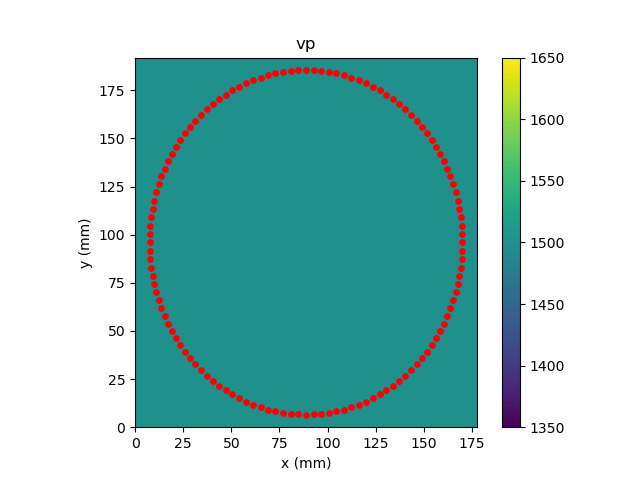

<IPython.core.display.Javascript object>


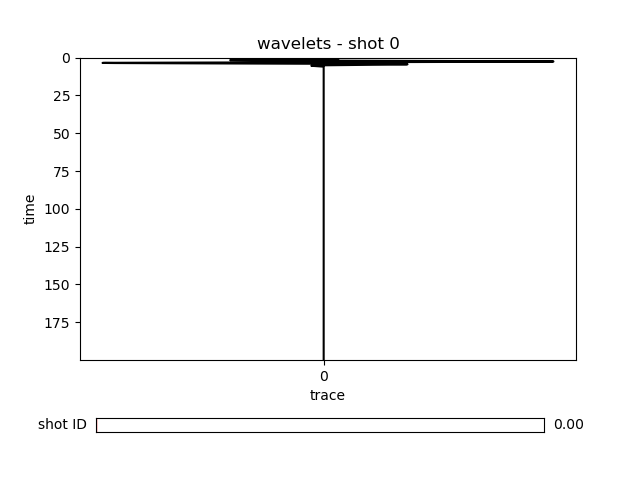

<IPython.core.display.Javascript object>


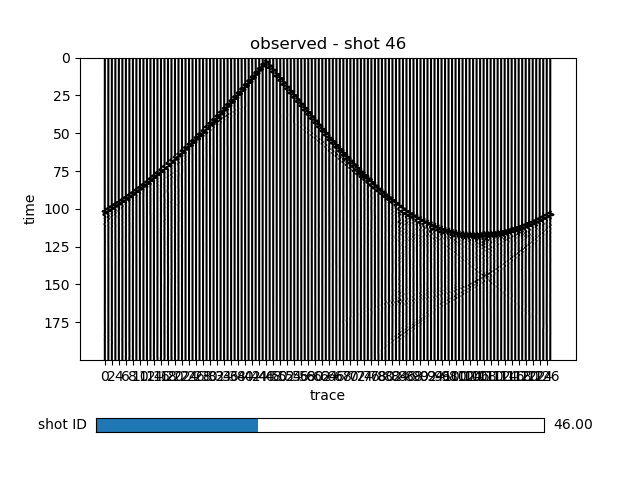

In [9]:
# Plot
problem.plot()

As we did for our forward run, we can now remotely instantiate our PDE across all available workers:

In [10]:
pde = IsoAcousticDevito.remote(grid=problem.grid, len=runtime.num_workers)

Next, we create a loss function. Here, we use the L2-norm of the distance between modelled and observed data as a metric:

In [11]:
loss = L2DistanceLoss.remote(len=runtime.num_workers)

We can now create an optimiser for our variable `vp`.

In this case, we choose gradient descent with a constant step size:

In [12]:
step_size = 10
process_grad = ProcessGlobalGradient()
process_model = ProcessModelIteration(min=1400., max=1700.)

optimiser = GradientDescent(vp, step_size=step_size,
                            process_grad=process_grad,
                            process_model=process_model)

You can see that we have also provided to the optimiser some pre-defined processing steps. These will be used to prepare the gradient before updating the variable, and to process the variable after the update. 

Among other things, these processing steps will normalise and smooth the gradient, and will clip the speed of sound of the updated model between 1400 m/s and 1700 m/s.

Let's now create an optimisation loop for our inversion:

In [13]:
optimisation_loop = OptimisationLoop()

Now, we are ready to execute the problem.

To obtain a better posed optimisation, we use a multi-scale approach. We will start our inversion by using only low frequencies to construct our model. As the inversion progresses, we will add higher frequencies until we reach the maximum desired level of detail.

We can do this by dividing our optimisation in `Block`s and specifying a maximum frequency. Each `Block` will run for a number of specified iterations.

During each iteration, only a subset of the shots will be used by defining the `select_shots` field. In this case, 16 shots will be used for each iteration, and they will be selected randomly without replacement.

In [ ]:
# Specify a series of frequency bands, which we will introduce gradually 
# into the inversion in order to better condition it
f_min = 0.05e6
max_freqs = [0.3e6, 0.4e6, 0.5e6, 0.6e6]

num_blocks = 4
num_iters = 8

# Start iterating over each block in the optimisation
for block, f_max in optimisation_loop.blocks(num_blocks, max_freqs):
    # We use pre-defined pipelines to process the source wavelets and the
    # observed and modelled traces. These will take care, among other things,
    # of filtering the data in frequency
    process_wavelets = ProcessWavelets.remote(f_min=f_min, f_max=f_max,
                                              len=runtime.num_workers)
    process_traces = ProcessTraces.remote(f_min=f_min, f_max=f_max,
                                          len=runtime.num_workers)

    # Proceed through every iteration in the block
    for iteration in block.iterations(num_iters):
        runtime.logger.info('Starting iteration %d (out of %d), '
                            'block %d (out of %d)' %
                            (iteration.id, block.num_iterations, block.id,
                             optimisation_loop.num_blocks))

        # Select some shots for this iteration
        shot_ids = problem.acquisitions.select_shot_ids(num=16, randomly=True)

        # Clear the gradient buffers of the variable
        vp.clear_grad()

        # Asynchronously loop over all the selected shot IDs
        @runtime.async_for(shot_ids)
        async def loop(worker, shot_id):
            runtime.logger.info('Giving shot %d to %s' % (shot_id, worker.uid))

            # Fetch one sub-problem corresponding to the shot ID
            sub_problem = problem.sub_problem(shot_id)
            wavelets = sub_problem.shot.wavelets
            observed = sub_problem.shot.observed

            # Pre-process the wavelets
            wavelets = process_wavelets(wavelets, runtime=worker)
            # Execute the PDE forward
            modelled = pde(wavelets, vp, problem=sub_problem, runtime=worker)

            # Pre-process the modelled and observed traces
            traces = process_traces(modelled, observed, runtime=worker)
            # and use these pre-processed versions to calculate the
            # value of the loss function
            fun = await loss(traces.outputs[0], traces.outputs[1],
                             problem=sub_problem, runtime=worker).result()

            iteration.add_fun(fun)
            runtime.logger.info('Functional value for shot %d: %s' % (shot_id, fun))

            # Now, we can calculate the gradient by executing the adjoint of the
            # forward process
            await fun.adjoint()

            runtime.logger.info('Retrieved gradient for shot %d' % sub_problem.shot_id)

        # Because this is an async loop, it needs to be awaited    
        _ = await loop
        # Update the vp with the calculated gradient by taking a step with the optimiser
        await optimiser.step()

        runtime.logger.info('Done iteration %d (out of %d), '
                            'block %d (out of %d) - Total loss %e' %
                            (iteration.id, block.num_iterations, block.id,
                             optimisation_loop.num_blocks, iteration.fun_value))
        runtime.logger.info('====================================================================')

# Plot the vp afterwards   
vp.plot()

As was the case for the forward example, we can obtain the same result by using a utility function that will run the default inversion workflow using `adjoint`:

In [ ]:
for block, freq in optimisation_loop.blocks(num_blocks, max_freqs):
    await adjoint(problem, pde, loss,
                  optimisation_loop, optimiser, vp,
                  num_iters=num_iters,
                  select_shots=dict(num=16, randomly=True),
                  f_min=0.05e6, f_max=freq)

vp.plot()

Before closing, we should tear down the mosaic runtime.

In [15]:
await mosaic.interactive('off')